In [1]:
# Neural Network Evaluation Benchmark

## Define Variables
PREDICTION_MODEL_NAME = 'trajectory_model10.h5'
SEQUENCE_LENGTH = 1600

## Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.signal import correlate

## Data Loading and Preprocessing

# Define file path
validation_test_file = 'own/data-int/4.csv'

# Function to load and preprocess data
def load_and_preprocess_data(validation_test_file):
    # Load the validation and test data
    validation_test_df = pd.read_csv(validation_test_file)
    
    # Convert 'date/time' columns to datetime
    validation_test_df['datetime'] = pd.to_datetime(validation_test_df['date/time'], errors='coerce')
    
    # Split validation_test_df into validation and test sets
    mid_index = len(validation_test_df) // 2
    val_df = validation_test_df.iloc[:mid_index]
    test_df = validation_test_df.iloc[mid_index:]
    
    return val_df, test_df

# Load datasets
val_df, test_df = load_and_preprocess_data(validation_test_file)

print('Loading complete')

2024-06-17 13:39:07.378537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 13:39:08.038552: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-17 13:39:08.038627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-

Loading complete


In [2]:
## Preprocessing

# Define features and targets
features = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z', 'x_cam', 'y_cam', 'z_cam']
targets = ['x', 'y']

# Scale the features
scaler = StandardScaler()
val_X_scaled = scaler.fit_transform(val_df[features])
test_X_scaled = scaler.transform(test_df[features])

# Extract target values
val_y = val_df[targets].values
test_y = test_df[targets].values

# Convert the data into sequences
def create_sequences(data, truth, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(truth[i+sequence_length])
    return np.array(sequences), np.array(labels)

X_val, y_val = create_sequences(val_X_scaled, val_y, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(test_X_scaled, test_y, SEQUENCE_LENGTH)

print('Input sequences complete')

Input sequences complete


In [3]:
## Model Prediction

# Load the model and predict using the test data
loaded_model = load_model(PREDICTION_MODEL_NAME)
y_pred = loaded_model.predict(X_test)

3042/3042 [==============================] - 406s 133ms/step


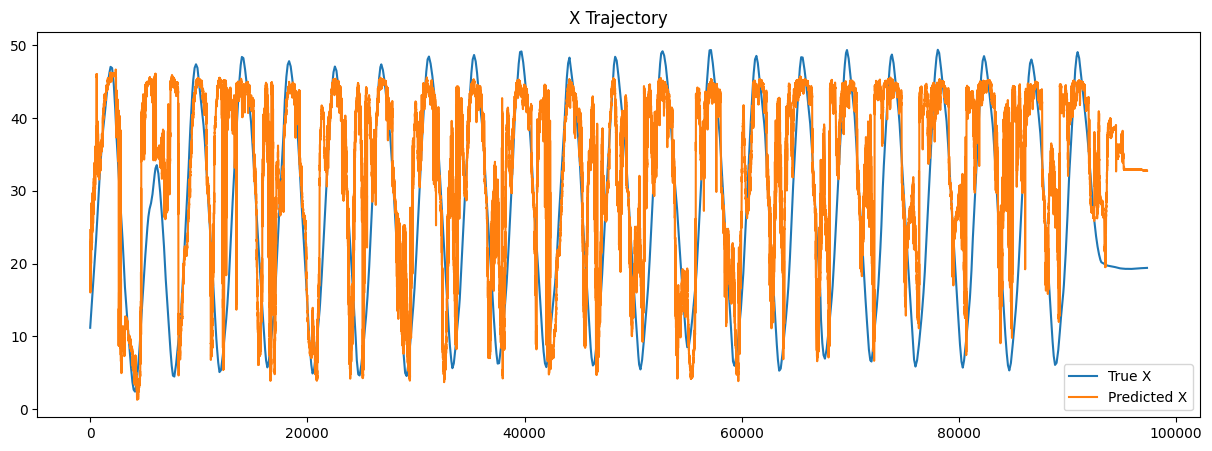

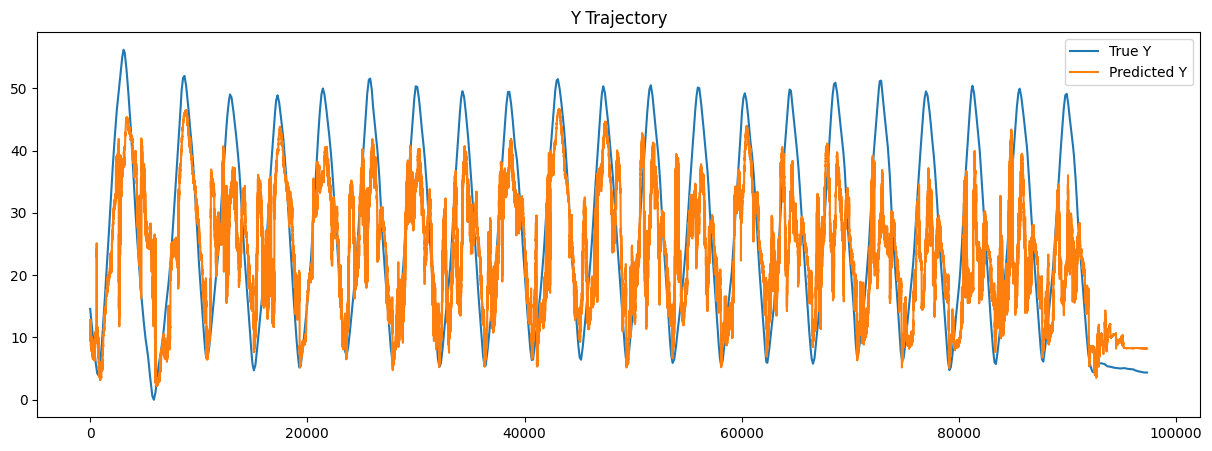

RMSE before filtering: 12.117849097677485


In [4]:
## First Evaluation: raw performance

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(y_pred[:, 0], label='Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(y_pred[:, 1], label='Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()

# Calculate the RMSE
rmse_before_filter = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE before filtering: {rmse_before_filter}')

RMSE after filtering: 11.623548262500101


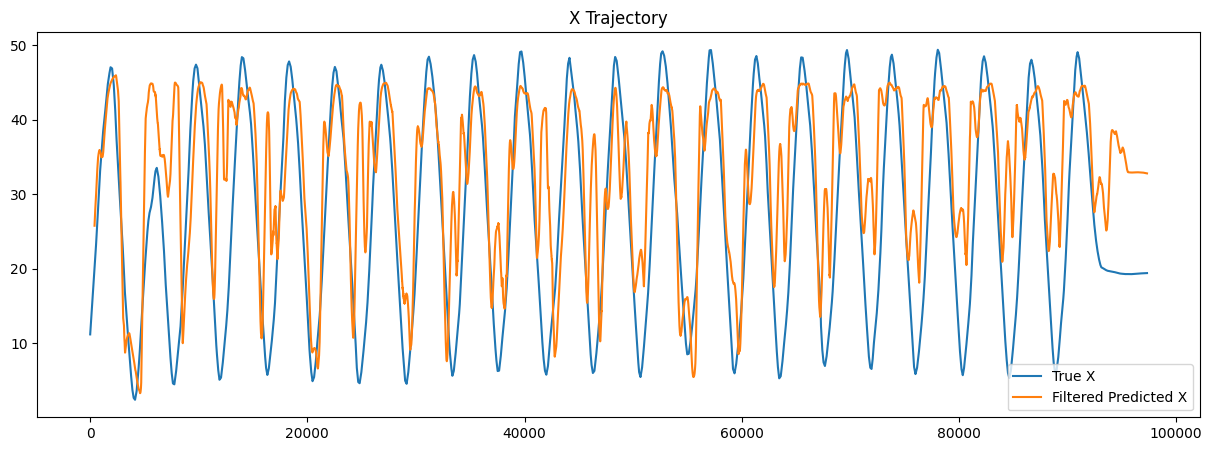

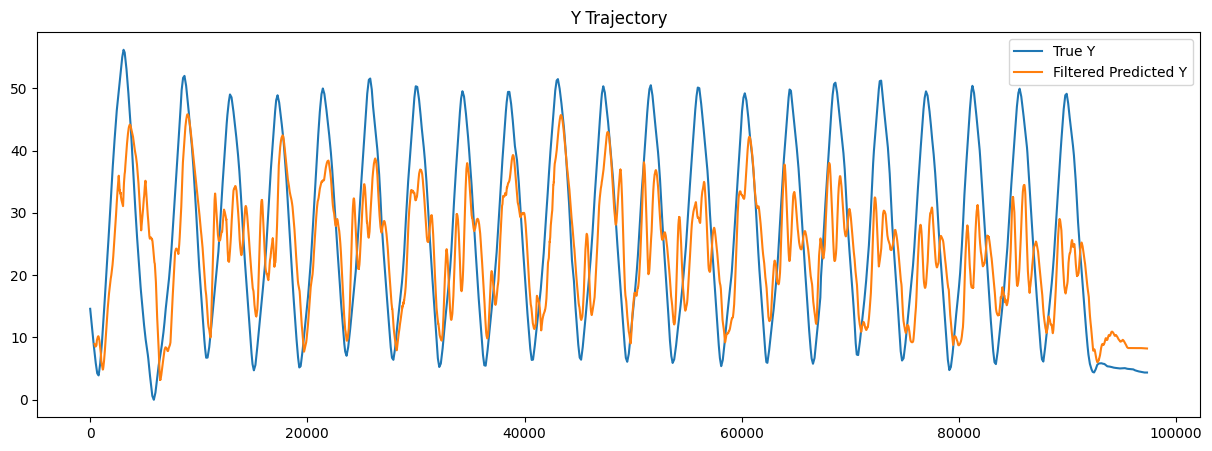

In [5]:
## Second Evaluation: basic filtering

# Apply a moving average filter to the predicted data
def moving_average(data, window_size=400):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average filter to each predicted dimension separately
y_pred_filtered = np.array([moving_average(y_pred[:, i]) for i in range(y_pred.shape[1])]).T

# Align the test data to match the length of the filtered predictions
y_test_aligned = y_test[len(y_test) - len(y_pred_filtered):]

# Calculate the RMSE again after filtering
rmse_after_filter = np.sqrt(mean_squared_error(y_test_aligned, y_pred_filtered))
print(f'RMSE after filtering: {rmse_after_filter}')

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(np.arange(len(y_test) - len(y_pred_filtered), len(y_test)), y_pred_filtered[:, 0], label='Filtered Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(np.arange(len(y_test) - len(y_pred_filtered), len(y_test)), y_pred_filtered[:, 1], label='Filtered Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()

Scaling factors: [3.92684299 4.86711905]
Shift values: [-113.95055749  -71.20652605]
Lags: X=-588, Y=-1305


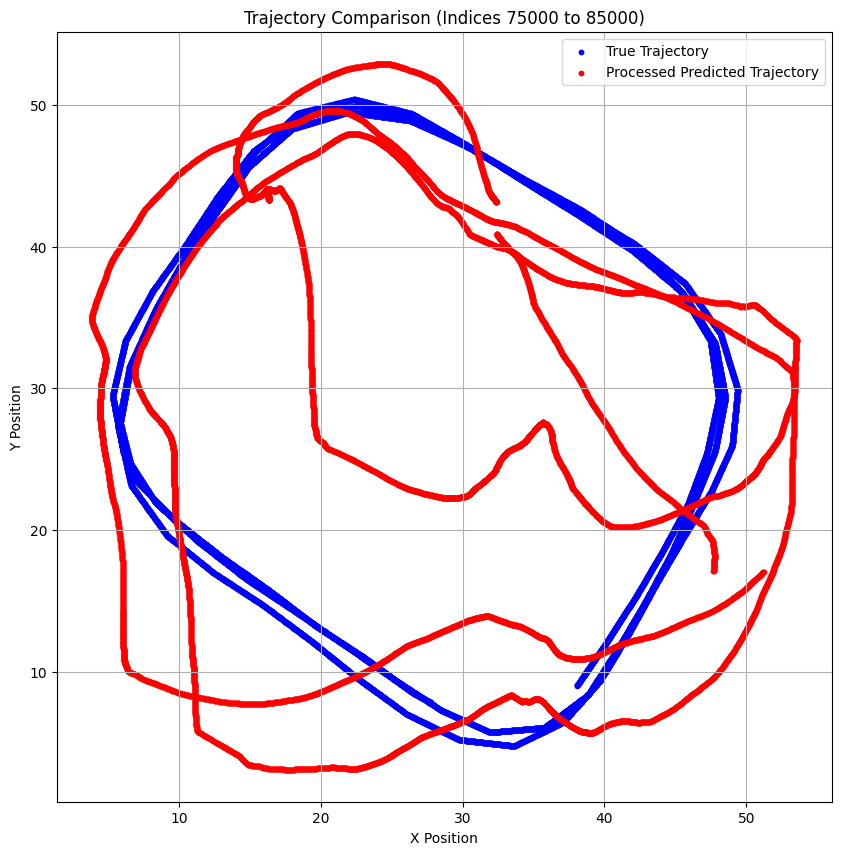

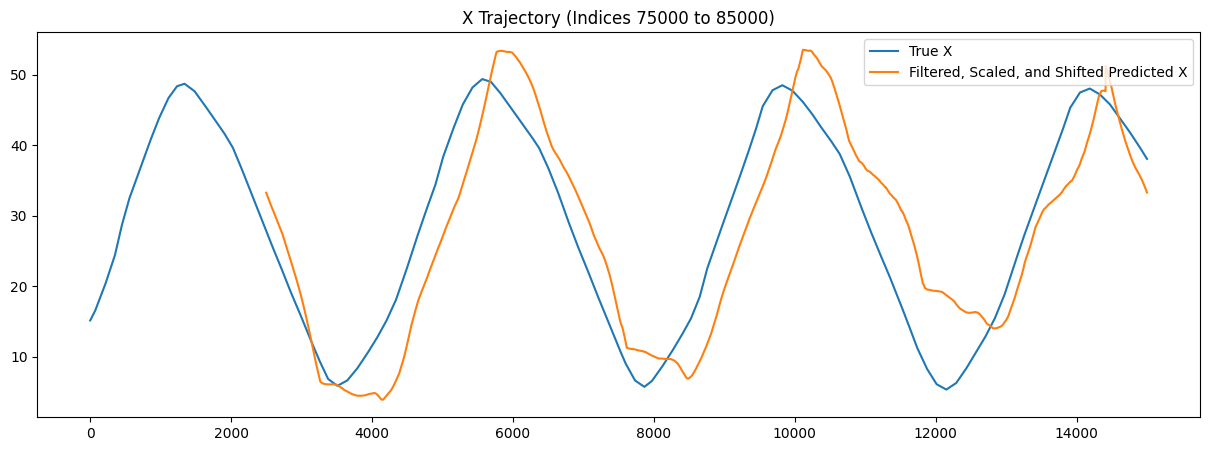

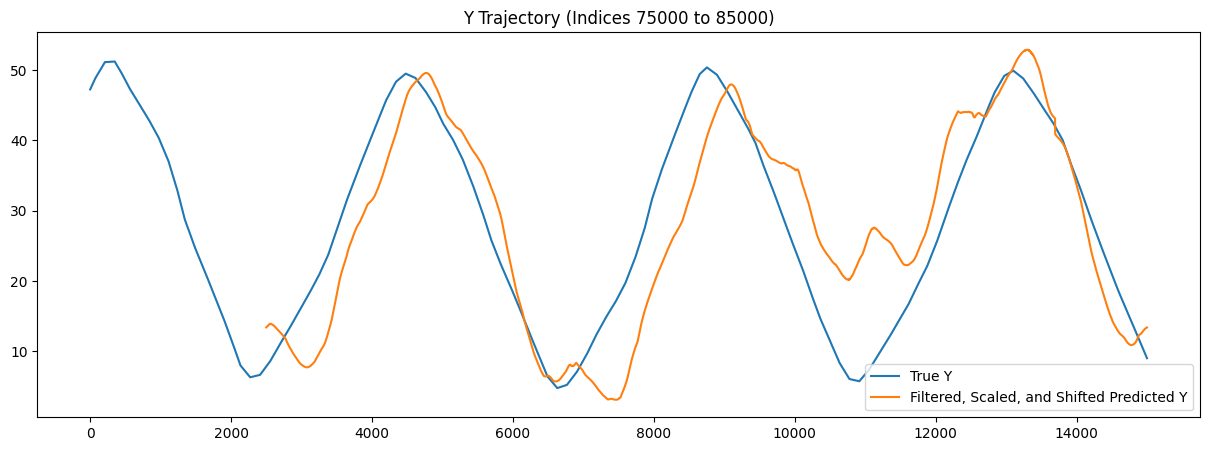

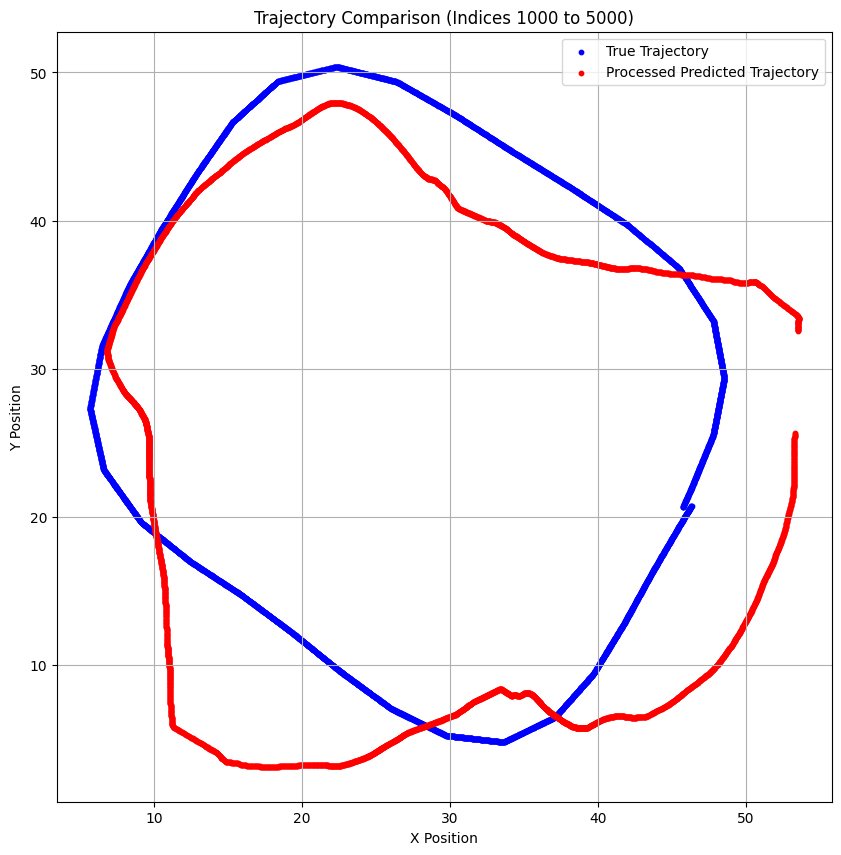

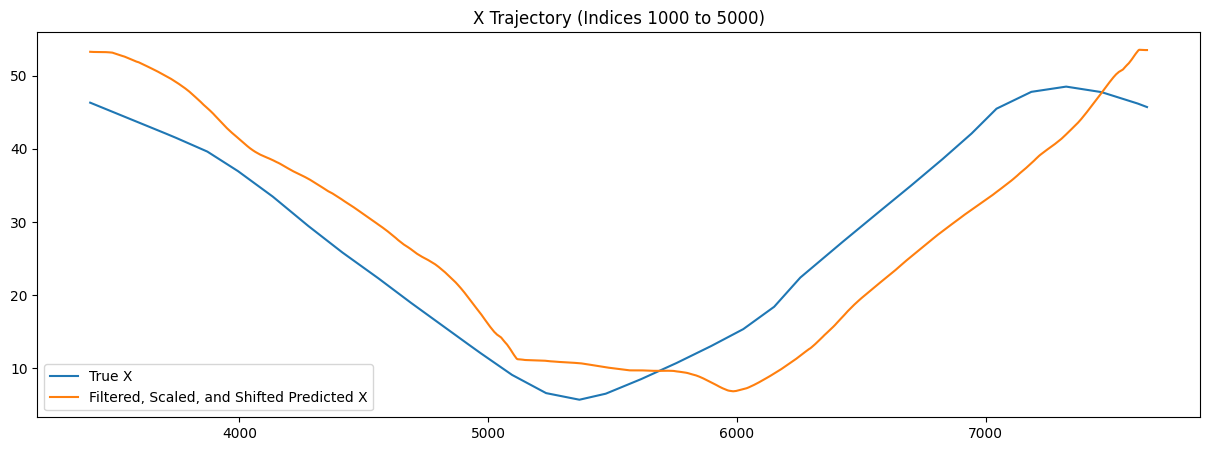

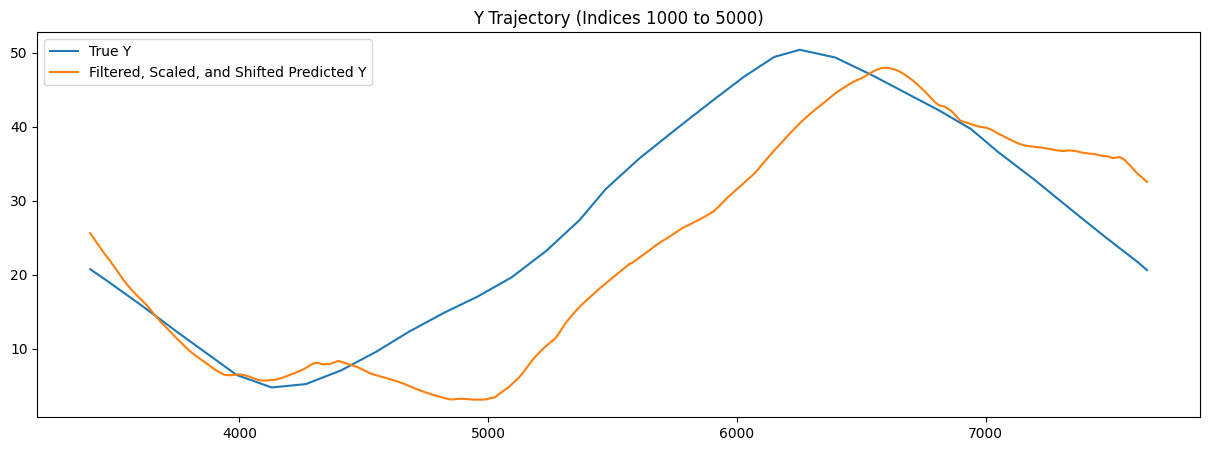

In [6]:
# Function to apply a moving average filter to the predicted data
def moving_average(data, window_size=2500):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Define the range of indices to use for processing
start_index = 72500
end_index = 87500

# Cut the data to only use the specified range for processing
y_test_cut = y_test[start_index:end_index]
y_pred_cut = y_pred[start_index:end_index]

# Apply moving average filter to each predicted dimension separately
y_pred_filtered = np.array([moving_average(y_pred_cut[:, i]) for i in range(y_pred_cut.shape[1])]).T

# Align the test data to match the length of the filtered predictions
y_test_aligned = y_test_cut[len(y_test_cut) - len(y_pred_filtered):]

# Calculate scaling factors using standard deviation
scaling_factors = np.std(y_test_aligned, axis=0) / np.std(y_pred_filtered, axis=0)

# Apply scaling factors to the filtered predicted data
y_pred_scaled = y_pred_filtered * scaling_factors

# Calculate the mean of the aligned ground truth and scaled predictions
mean_y_test = np.mean(y_test_aligned, axis=0)
mean_y_pred = np.mean(y_pred_scaled, axis=0)

# Calculate the shift required to align the means
shift = mean_y_test - mean_y_pred

# Apply the shift to the scaled predicted data
y_pred_scaled_shifted = y_pred_scaled + shift

# Determine the lag that maximizes the cross-correlation between the ground truth and the predicted data
def find_best_shift(y_true, y_pred):
    correlation = correlate(y_true, y_pred)
    lag = correlation.argmax() - (len(y_pred) - 1)
    return lag

# Apply the best shift for each dimension
lag_x = find_best_shift(y_test_aligned[:, 0], y_pred_scaled_shifted[:, 0])
lag_y = find_best_shift(y_test_aligned[:, 1], y_pred_scaled_shifted[:, 1])

# Create copies of the data to apply the shifts
y_pred_final_x = np.roll(y_pred_scaled_shifted[:, 0], shift=lag_x)
y_pred_final_y = np.roll(y_pred_scaled_shifted[:, 1], shift=lag_y)

# Combine the shifted dimensions back into a single array
y_pred_final = np.column_stack((y_pred_final_x, y_pred_final_y))

# Print the used scaling factors, shift values, and lag values
print(f'Scaling factors: {scaling_factors}')
print(f'Shift values: {shift}')
print(f'Lags: X={lag_x}, Y={lag_y}')

# Store the data in temp.csv
df = pd.DataFrame({
    'True_X': y_test_aligned[:, 0],
    'True_Y': y_test_aligned[:, 1],
    'Pred_X': y_pred_final[:, 0],
    'Pred_Y': y_pred_final[:, 1]
})
df.to_csv('temp.csv', index=False)

# Load the data from temp.csv
df = pd.read_csv('temp.csv')

# Extract the required range of samples
plot_data = df.iloc[3400:7650]

# Original plots
# Plot the results for both X and Y trajectories on the same plot as dots (75,000 to 85,000)
plt.figure(figsize=(10, 10))
plt.scatter(y_test_aligned[:, 0], y_test_aligned[:, 1], label='True Trajectory', color='blue', s=10)
plt.scatter(y_pred_final[:, 0], y_pred_final[:, 1], label='Processed Predicted Trajectory', color='red', s=10)
plt.legend()
plt.title('Trajectory Comparison (Indices 75000 to 85000)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid(True)
plt.show()

# Separate plots for X and Y trajectories (75,000 to 85,000)
plt.figure(figsize=(15, 5))
plt.plot(y_test_cut[:, 0], label='True X')
plt.plot(np.arange(len(y_test_cut) - len(y_pred_final), len(y_test_cut)), y_pred_final[:, 0], label='Filtered, Scaled, and Shifted Predicted X')
plt.legend()
plt.title('X Trajectory (Indices 75000 to 85000)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test_cut[:, 1], label='True Y')
plt.plot(np.arange(len(y_test_cut) - len(y_pred_final), len(y_test_cut)), y_pred_final[:, 1], label='Filtered, Scaled, and Shifted Predicted Y')
plt.legend()
plt.title('Y Trajectory (Indices 75000 to 85000)')
plt.show()

# New plots
# Plot the results for both X and Y trajectories on the same plot as dots (1000th to 5000th sample)
plt.figure(figsize=(10, 10))
plt.scatter(plot_data['True_X'], plot_data['True_Y'], label='True Trajectory', color='blue', s=10)
plt.scatter(plot_data['Pred_X'], plot_data['Pred_Y'], label='Processed Predicted Trajectory', color='red', s=10)
plt.legend()
plt.title('Trajectory Comparison (Indices 1000 to 5000)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid(True)
plt.show()

# Separate plots for X and Y trajectories (1000th to 5000th sample)
plt.figure(figsize=(15, 5))
plt.plot(plot_data['True_X'], label='True X')
plt.plot(plot_data['Pred_X'], label='Filtered, Scaled, and Shifted Predicted X')
plt.legend()
plt.title('X Trajectory (Indices 1000 to 5000)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(plot_data['True_Y'], label='True Y')
plt.plot(plot_data['Pred_Y'], label='Filtered, Scaled, and Shifted Predicted Y')
plt.legend()
plt.title('Y Trajectory (Indices 1000 to 5000)')
plt.show()

In [7]:
# Define additional file paths
file_6 = 'own/data-int/6.csv'
file_7 = 'own/data-int/7.csv'

# Function to load and preprocess a single file
def load_and_preprocess_file(file, start_offset, end_offset):
    df = pd.read_csv(file)
    df['datetime'] = pd.to_datetime(df['date/time'], errors='coerce')
    start_time = df['datetime'].min() + pd.Timedelta(minutes=start_offset)
    end_time = df['datetime'].max() - pd.Timedelta(minutes=end_offset)
    return df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]

# Load and preprocess data for file 6
df_6 = load_and_preprocess_file(file_6, start_offset=2, end_offset=1)
additional_X_scaled_6 = scaler.transform(df_6[features])
additional_y_6 = df_6[targets].values
X_additional_6, y_additional_6 = create_sequences(additional_X_scaled_6, additional_y_6, SEQUENCE_LENGTH)

# Load and preprocess data for file 7
df_7 = load_and_preprocess_file(file_7, start_offset=1, end_offset=1)
additional_X_scaled_7 = scaler.transform(df_7[features])
additional_y_7 = df_7[targets].values
X_additional_7, y_additional_7 = create_sequences(additional_X_scaled_7, additional_y_7, SEQUENCE_LENGTH)

print('Loading and preprocessing for 6.csv and 7.csv complete')


Loading and preprocessing for 6.csv and 7.csv complete


3226/3226 [==============================] - 430s 133ms/step


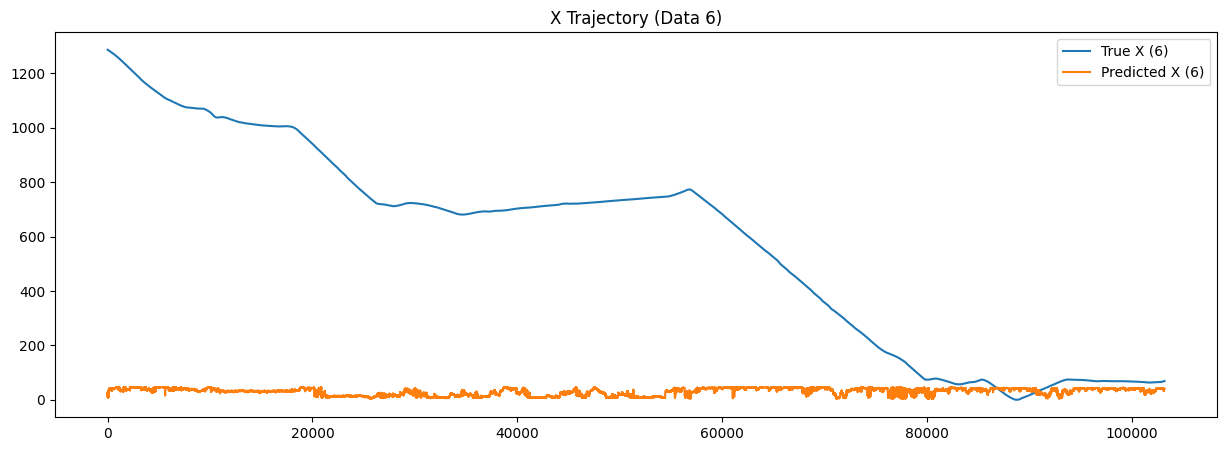

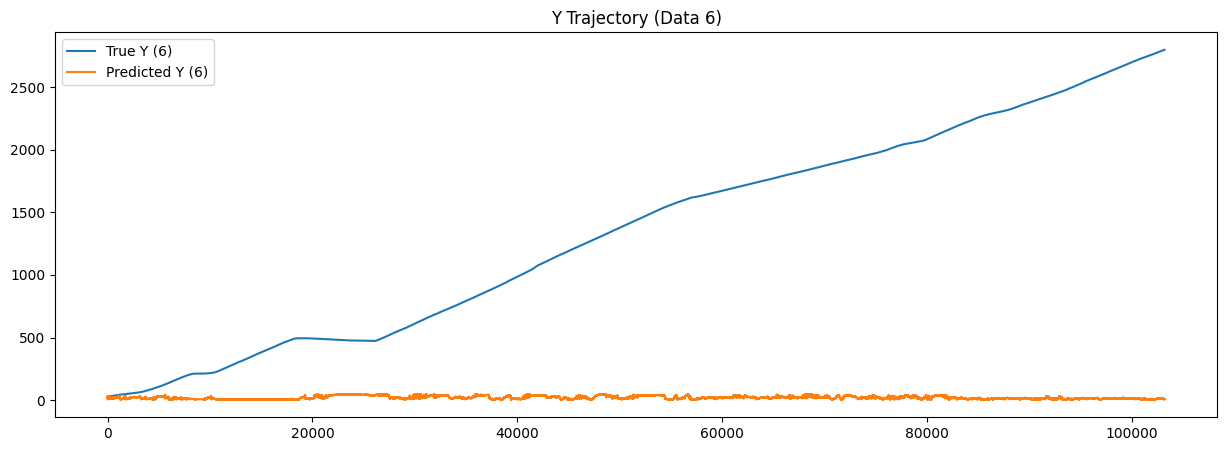

Scaling factors for 6: [34.41560495 91.38664969]
Shift values for 6: [-478.41446583 -455.4747921 ]
Lags for 6: X=-53195, Y=19228


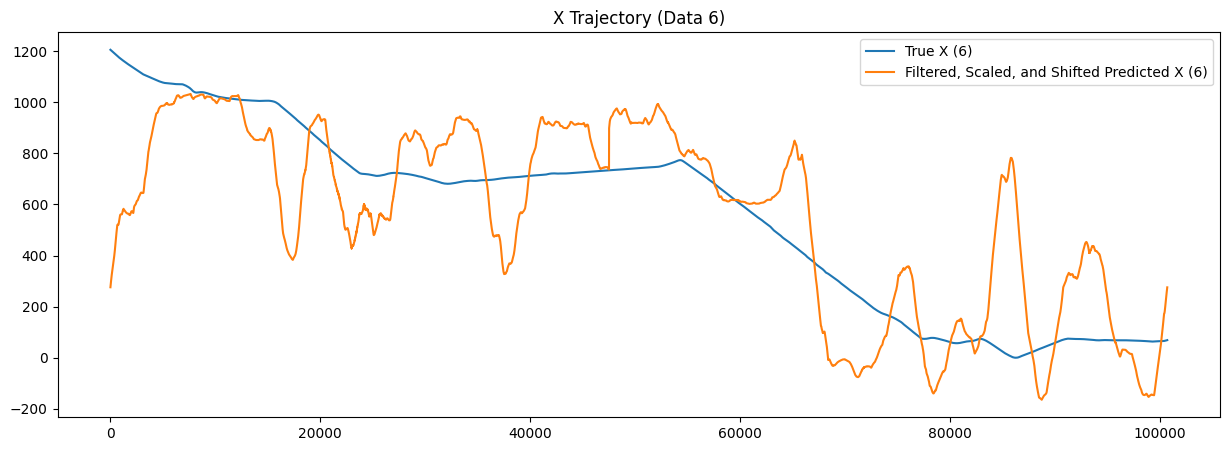

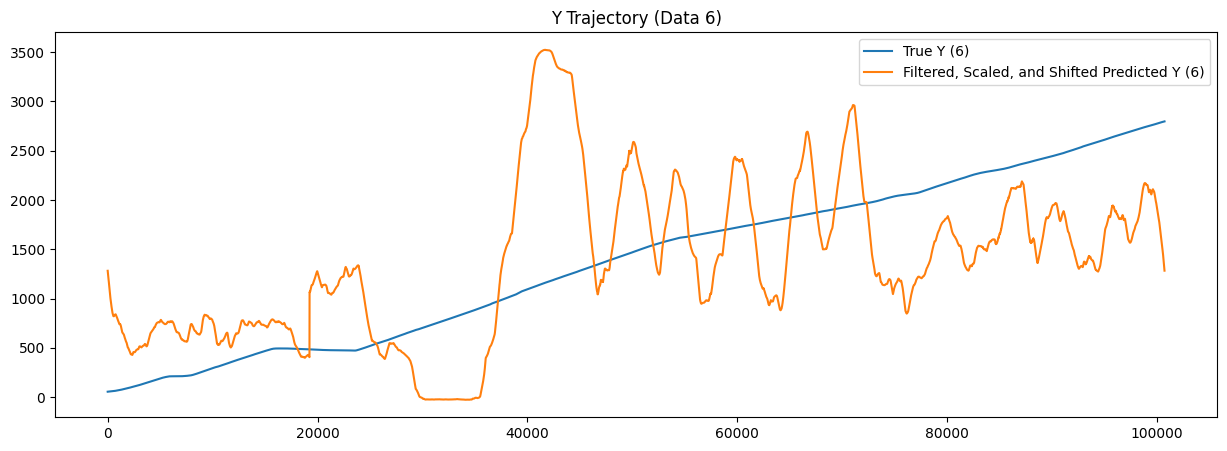

In [ ]:
## Model Prediction for Data 6

# Predict using the additional data for 6.csv
y_additional_pred_6 = loaded_model.predict(X_additional_6)

# Plot the results for additional data 6
plt.figure(figsize=(15, 5))
plt.plot(y_additional_6[:, 0], label='True X (6)')
plt.plot(y_additional_pred_6[:, 0], label='Predicted X (6)')
plt.legend()
plt.title('X Trajectory (Data 6)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_additional_6[:, 1], label='True Y (6)')
plt.plot(y_additional_pred_6[:, 1], label='Predicted Y (6)')
plt.legend()
plt.title('Y Trajectory (Data 6)')
plt.show()

# Apply Moving Average Filter, Scaling, Shifting, and Lag Correction to Data 6

# Apply moving average filter to additional predicted data for 6
y_additional_pred_filtered_6 = np.array([moving_average(y_additional_pred_6[:, i]) for i in range(y_additional_pred_6.shape[1])]).T

# Align the additional test data to match the length of the filtered predictions
y_additional_test_aligned_6 = y_additional_6[len(y_additional_6) - len(y_additional_pred_filtered_6):]

# Calculate scaling factors using standard deviation for 6
scaling_factors_6 = np.std(y_additional_test_aligned_6, axis=0) / np.std(y_additional_pred_filtered_6, axis=0)

# Apply scaling factors to the filtered predicted data for 6
y_additional_pred_scaled_6 = y_additional_pred_filtered_6 * scaling_factors_6

# Calculate the mean of the aligned ground truth and scaled predictions for 6
mean_y_additional_test_6 = np.mean(y_additional_test_aligned_6, axis=0)
mean_y_additional_pred_6 = np.mean(y_additional_pred_scaled_6, axis=0)

# Calculate the shift required to align the means for 6
additional_shift_6 = mean_y_additional_test_6 - mean_y_additional_pred_6

# Apply the shift to the scaled predicted data for 6
y_additional_pred_scaled_shifted_6 = y_additional_pred_scaled_6 + additional_shift_6

# Determine the lag that maximizes the cross-correlation between the ground truth and the predicted data for 6
additional_lag_x_6 = find_best_shift(y_additional_test_aligned_6[:, 0], y_additional_pred_scaled_shifted_6[:, 0])
additional_lag_y_6 = find_best_shift(y_additional_test_aligned_6[:, 1], y_additional_pred_scaled_shifted_6[:, 1])

# Create copies of the data to apply the shifts for 6
y_additional_pred_final_x_6 = np.roll(y_additional_pred_scaled_shifted_6[:, 0], shift=additional_lag_x_6)
y_additional_pred_final_y_6 = np.roll(y_additional_pred_scaled_shifted_6[:, 1], shift=additional_lag_y_6)

# Combine the shifted dimensions back into a single array for 6
y_additional_pred_final_6 = np.column_stack((y_additional_pred_final_x_6, y_additional_pred_final_y_6))

# Print the used scaling factors, shift values, and lag values for 6
print(f'Scaling factors for 6: {scaling_factors_6}')
print(f'Shift values for 6: {additional_shift_6}')
print(f'Lags for 6: X={additional_lag_x_6}, Y={additional_lag_y_6}')

# Plot the results for 6 after filtering, scaling, shifting, and lag correction
plt.figure(figsize=(15, 5))
plt.plot(y_additional_test_aligned_6[:, 0], label='True X (6)')
plt.plot(np.arange(len(y_additional_test_aligned_6) - len(y_additional_pred_final_6), len(y_additional_test_aligned_6)), y_additional_pred_final_6[:, 0], label='Filtered, Scaled, and Shifted Predicted X (6)')
plt.legend()
plt.title('X Trajectory (Data 6)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_additional_test_aligned_6[:, 1], label='True Y (6)')
plt.plot(np.arange(len(y_additional_test_aligned_6) - len(y_additional_pred_final_6), len(y_additional_test_aligned_6)), y_additional_pred_final_6[:, 1], label='Filtered, Scaled, and Shifted Predicted Y (6)')
plt.legend()
plt.title('Y Trajectory (Data 6)')
plt.show()


1557/1557 [==============================] - 207s 133ms/step


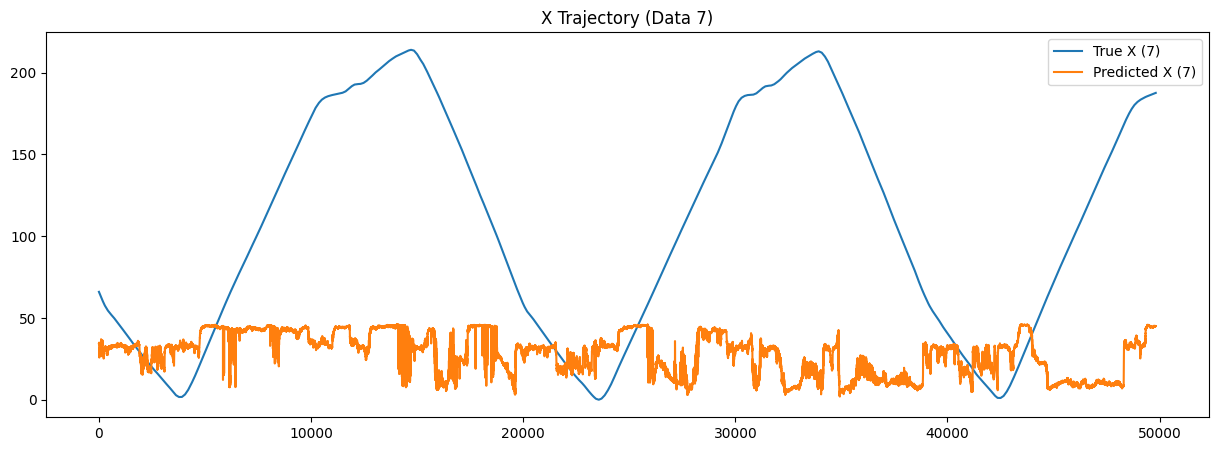

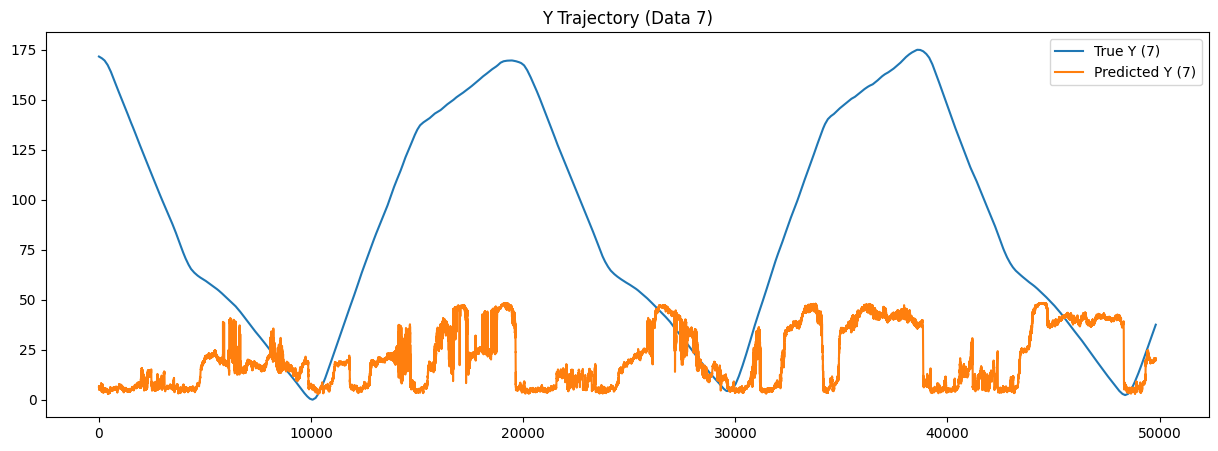

Scaling factors for 7: [7.71498509 4.97535836]
Shift values for 7: [-105.32028127  -21.58778726]
Lags for 7: X=3901, Y=-977


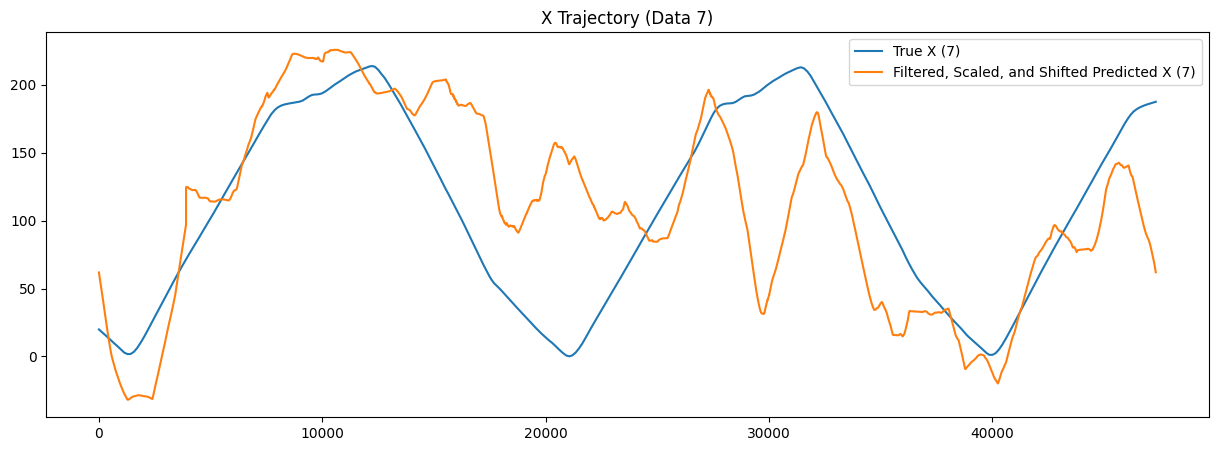

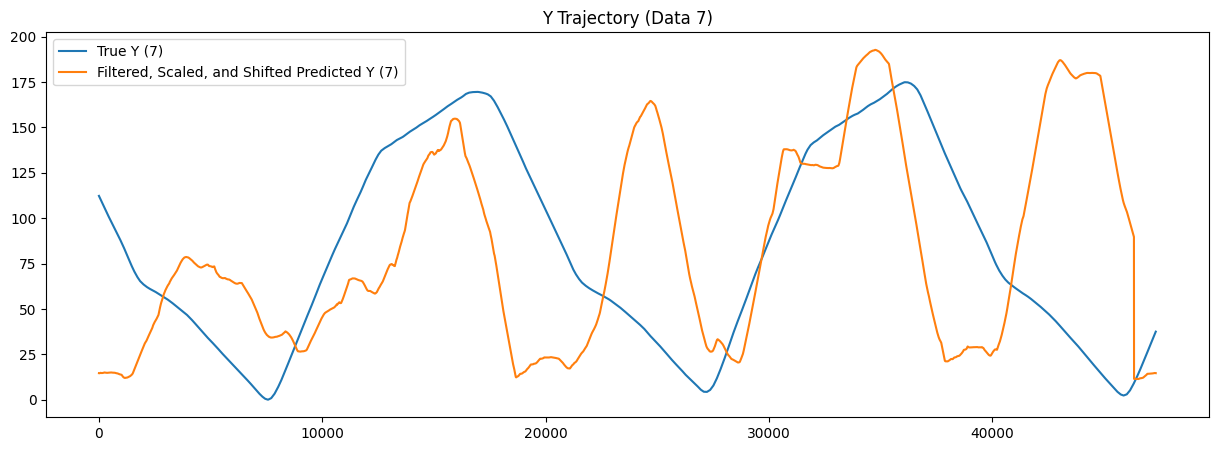

In [ ]:
## Model Prediction for Data 7

# Predict using the additional data for 7.csv
y_additional_pred_7 = loaded_model.predict(X_additional_7)

# Plot the results for additional data 7
plt.figure(figsize=(15, 5))
plt.plot(y_additional_7[:, 0], label='True X (7)')
plt.plot(y_additional_pred_7[:, 0], label='Predicted X (7)')
plt.legend()
plt.title('X Trajectory (Data 7)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_additional_7[:, 1], label='True Y (7)')
plt.plot(y_additional_pred_7[:, 1], label='Predicted Y (7)')
plt.legend()
plt.title('Y Trajectory (Data 7)')
plt.show()

# Apply Moving Average Filter, Scaling, Shifting, and Lag Correction to Data 7

# Apply moving average filter to additional predicted data for 7
y_additional_pred_filtered_7 = np.array([moving_average(y_additional_pred_7[:, i]) for i in range(y_additional_pred_7.shape[1])]).T

# Align the additional test data to match the length of the filtered predictions
y_additional_test_aligned_7 = y_additional_7[len(y_additional_7) - len(y_additional_pred_filtered_7):]

# Calculate scaling factors using standard deviation for 7
scaling_factors_7 = np.std(y_additional_test_aligned_7, axis=0) / np.std(y_additional_pred_filtered_7, axis=0)

# Apply scaling factors to the filtered predicted data for 7
y_additional_pred_scaled_7 = y_additional_pred_filtered_7 * scaling_factors_7

# Calculate the mean of the aligned ground truth and scaled predictions for 7
mean_y_additional_test_7 = np.mean(y_additional_test_aligned_7, axis=0)
mean_y_additional_pred_7 = np.mean(y_additional_pred_scaled_7, axis=0)

# Calculate the shift required to align the means for 7
additional_shift_7 = mean_y_additional_test_7 - mean_y_additional_pred_7

# Apply the shift to the scaled predicted data for 7
y_additional_pred_scaled_shifted_7 = y_additional_pred_scaled_7 + additional_shift_7

# Determine the lag that maximizes the cross-correlation between the ground truth and the predicted data for 7
additional_lag_x_7 = find_best_shift(y_additional_test_aligned_7[:, 0], y_additional_pred_scaled_shifted_7[:, 0])
additional_lag_y_7 = find_best_shift(y_additional_test_aligned_7[:, 1], y_additional_pred_scaled_shifted_7[:, 1])

# Create copies of the data to apply the shifts for 7
y_additional_pred_final_x_7 = np.roll(y_additional_pred_scaled_shifted_7[:, 0], shift=additional_lag_x_7)
y_additional_pred_final_y_7 = np.roll(y_additional_pred_scaled_shifted_7[:, 1], shift=additional_lag_y_7)

# Combine the shifted dimensions back into a single array for 7
y_additional_pred_final_7 = np.column_stack((y_additional_pred_final_x_7, y_additional_pred_final_y_7))

# Print the used scaling factors, shift values, and lag values for 7
print(f'Scaling factors for 7: {scaling_factors_7}')
print(f'Shift values for 7: {additional_shift_7}')
print(f'Lags for 7: X={additional_lag_x_7}, Y={additional_lag_y_7}')

# Plot the results for 7 after filtering, scaling, shifting, and lag correction
plt.figure(figsize=(15, 5))
plt.plot(y_additional_test_aligned_7[:, 0], label='True X (7)')
plt.plot(np.arange(len(y_additional_test_aligned_7) - len(y_additional_pred_final_7), len(y_additional_test_aligned_7)), y_additional_pred_final_7[:, 0], label='Filtered, Scaled, and Shifted Predicted X (7)')
plt.legend()
plt.title('X Trajectory (Data 7)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_additional_test_aligned_7[:, 1], label='True Y (7)')
plt.plot(np.arange(len(y_additional_test_aligned_7) - len(y_additional_pred_final_7), len(y_additional_test_aligned_7)), y_additional_pred_final_7[:, 1], label='Filtered, Scaled, and Shifted Predicted Y (7)')
plt.legend()
plt.title('Y Trajectory (Data 7)')
plt.show()


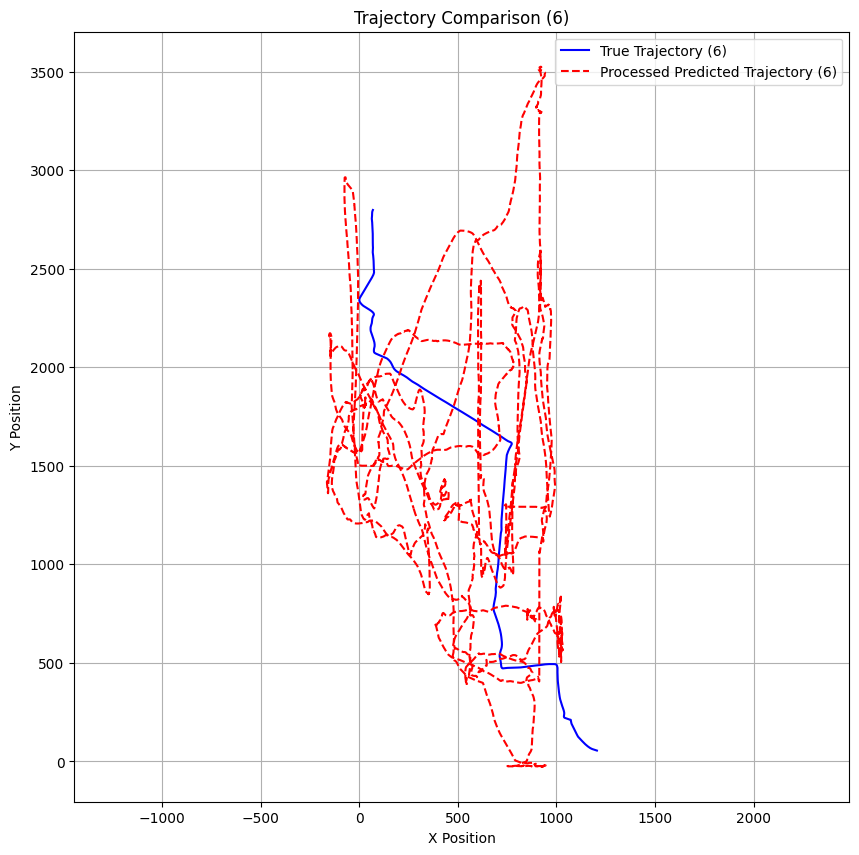

In [ ]:
# Plot X vs Y Trajectory
plt.figure(figsize=(10, 10))
plt.plot(y_additional_test_aligned_6[:, 0], y_additional_test_aligned_6[:, 1], label='True Trajectory (6)', color='blue')
plt.plot(y_additional_pred_final_6[:, 0], y_additional_pred_final_6[:, 1], label='Processed Predicted Trajectory (6)', color='red', linestyle='dashed')
plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectory Comparison (6)')
plt.axis('equal')
plt.grid(True)
plt.show()

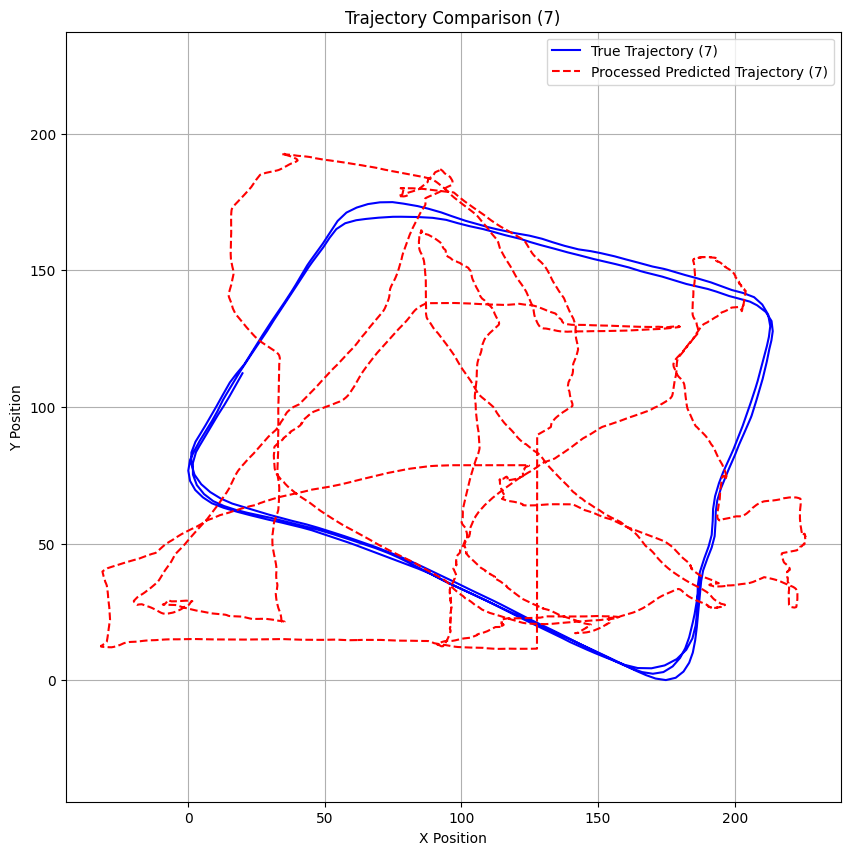

In [ ]:
# Plot X vs Y Trajectory
plt.figure(figsize=(10, 10))
plt.plot(y_additional_test_aligned_7[:, 0], y_additional_test_aligned_7[:, 1], label='True Trajectory (7)', color='blue')
plt.plot(y_additional_pred_final_7[:, 0], y_additional_pred_final_7[:, 1], label='Processed Predicted Trajectory (7)', color='red', linestyle='dashed')
plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectory Comparison (7)')
plt.axis('equal')
plt.grid(True)
plt.show()